# Predict daily bike rental ridership

In [7]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load and prepare the data

In [8]:
data_path = '/home/dpk/Downloads/dlnd-project-1/dlnd-project-1/bike-sharing-dataset/hour.csv'

rides = pd.read_csv(data_path)

In [9]:
rides.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


## Checking out the data

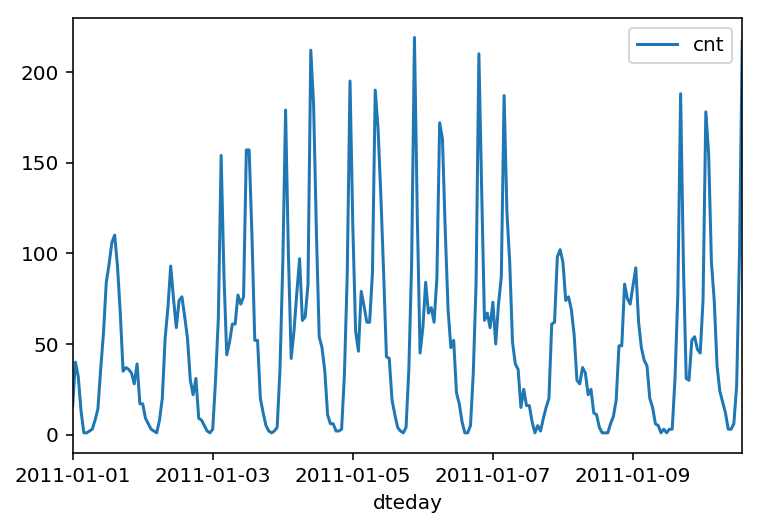

In [10]:
rides[:24*10].plot(x='dteday', y='cnt')

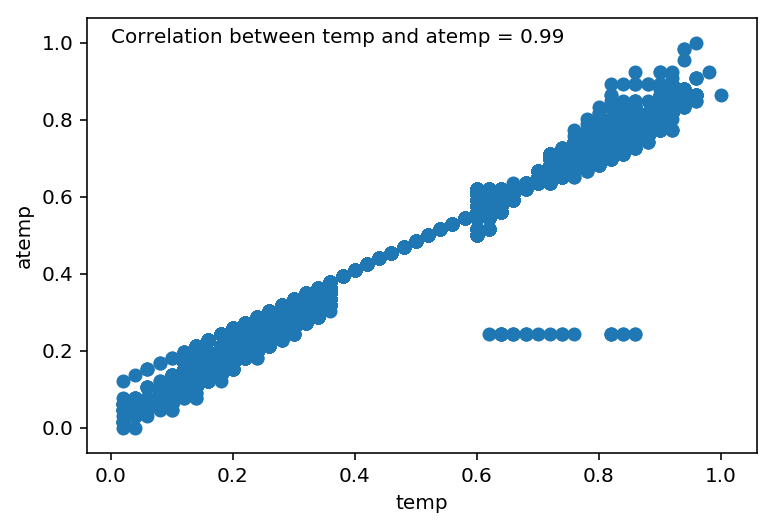

In [11]:
plt.scatter(rides.loc[:,'temp'],rides.loc[:,'atemp'])
correlation = round(rides.loc[:,'temp'].corr(rides.loc[:,'atemp']),2)
plt.text(x=0,y=1,s="Correlation between temp and atemp = "+str(correlation))
plt.xlabel("temp")
plt.ylabel("atemp")

### Dummy variables

In [12]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'hr']
data = rides.drop(fields_to_drop, axis=1)
data.head()

,yr,holiday,workingday,temp,hum,windspeed,casual,registered,cnt,season_1,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0,0.24,0.81,0.0,3,13,16,1,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0.22,0.80,0.0,8,32,40,1,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0.22,0.80,0.0,5,27,32,1,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0.24,0.75,0.0,3,10,13,1,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0.24,0.75,0.0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,1


In [13]:
print(data.loc[:,'workingday'].value_counts())
print((data.loc[:'cnt'].groupby(['workingday'])).mean()['cnt'])

1    11865
0     5514
Name: workingday, dtype: int64
workingday
0    181.405332
1    193.207754
Name: cnt, dtype: float64


### Scaling target variables

In [ ]:
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']

scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

### Splitting the data into training, testing, and validation sets

In [15]:
# Save the last 21 days 
test_data = data[-21*24:]
data = data[:-21*24]

# Separate the data into features and targets
target_fields = ['cnt', 'casual', 'registered']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

In [16]:
n_records = features.shape[0]
split = np.random.choice(features.index, 
                         size=int(n_records*0.8), 
                         replace=False)
train_features, train_targets = features.ix[split], targets.ix[split]
val_features, val_targets = features.drop(split), targets.drop(split)

## Build the network

In [17]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

class NeuralNetwork:
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate,l2 = 0):
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes

        self.weights_input_to_hidden = np.random.normal(0.0, self.hidden_nodes**-0.5, 
                                                (self.hidden_nodes, self.input_nodes))
    
        self.weights_hidden_to_output = np.random.normal(0.0, self.output_nodes**-0.5, 
                                                (self.output_nodes, self.hidden_nodes))
        
        self.learning_rate = learning_rate
        self.l2=l2
        
        self.activation_function = sigmoid
    
    def train(self, inputs_list, targets_list):
        
        inputs = np.array(inputs_list, ndmin=2).T
        targets = np.array(targets_list, ndmin = 2).T
        
        hidden_inputs = np.dot(self.weights_input_to_hidden,inputs)
        hidden_outputs = sigmoid(hidden_inputs)
        
        final_inputs = np.dot(self.weights_hidden_to_output,hidden_outputs)
        final_outputs = final_inputs

        output_errors = targets-final_outputs# Output layer error is the difference between desired target and actual output.
        del_ouput = output_errors
        

        hidden_errors = np.dot(self.weights_hidden_to_output.T,output_errors)# errors propagated to the hidden layer
        hidden_grad = hidden_outputs*(1-hidden_outputs)# hidden layer gradients
        del_hidden = hidden_errors*hidden_grad
  
        
        self.weights_hidden_to_output = (1-self.learning_rate*self.l2/len(inputs))*self.weights_hidden_to_output +self.learning_rate*del_ouput*hidden_outputs.T# update hidden-to-output weights with gradient descent step
        self.weights_input_to_hidden = (1-self.learning_rate*self.l2/len(inputs))*self.weights_input_to_hidden + self.learning_rate*inputs.T*del_hidden# update input-to-hidden weights with gradient descent step
        
    def run(self, inputs_list):
        # Run a forward pass through the network
        inputs = np.array(inputs_list, ndmin=2).T
        
        hidden_inputs = np.dot(self.weights_input_to_hidden,inputs)
        hidden_outputs = sigmoid(hidden_inputs)
        

        final_inputs = np.dot(self.weights_hidden_to_output,hidden_outputs)
        final_outputs = final_inputs
        
        return final_outputs

In [18]:
def MSE(y, Y):
    return np.mean((y-Y)**2)

## Training the network

In [ ]:

epochs = 5000
learning_rate = 0.2
hidden_nodes = 30
output_nodes = 1
l2=0.15
N_i = train_features.shape[1]
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate,l2)

losses = {'train':[], 'validation':[]}
for e in range(epochs):
    # Go through a random batch of 128 records from the training data set
    batch = np.random.choice(train_features.index, size=128)
    for record, target in zip(train_features.ix[batch].values, 
                              train_targets.ix[batch]['cnt']):
        network.train(record, target)
    
    if e%(epochs/10) == 0:
        # Calculate losses for the training and test sets
        train_loss = MSE(network.run(train_features), train_targets['cnt'].values)
        val_loss = MSE(network.run(val_features), val_targets['cnt'].values)
        losses['train'].append(train_loss)
        losses['validation'].append(val_loss)
        
        # Print out the losses as the network is training
        print('Training loss: {:.4f}'.format(train_loss))
        print('Validation loss: {:.4f}'.format(val_loss))
        

In [ ]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()

## Check out your predictions

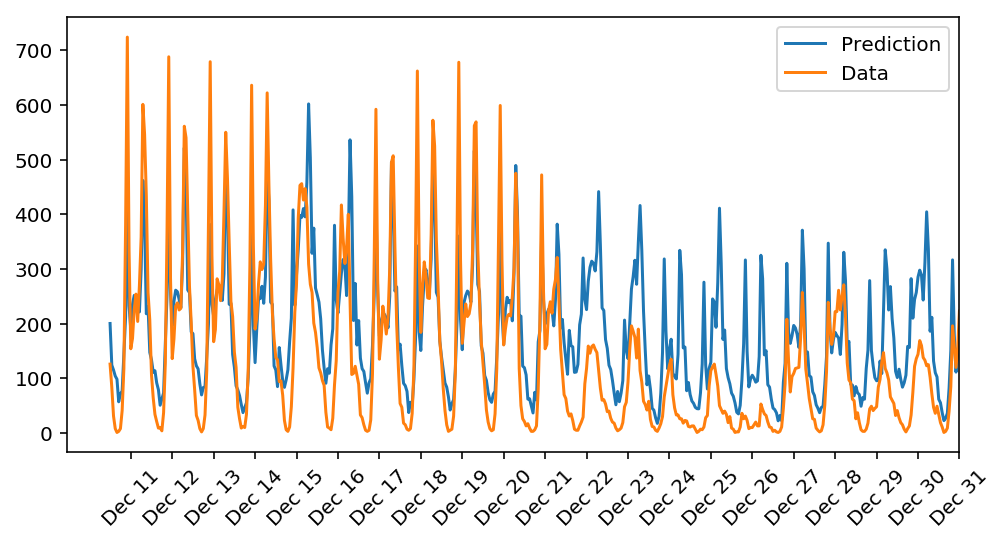

In [22]:
fig, ax = plt.subplots(figsize=(8,4))

mean, std = scaled_features['cnt']
predictions = network.run(test_features)*std + mean
ax.plot(predictions[0], label='Prediction')
target_val=test_targets['cnt']*std + mean
ax.plot((target_val).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(rides.ix[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)

In [23]:
target_val=target_val.values.reshape((1,-1))
print("RMSE on test data is: ",((predictions-target_val[np.newaxis].T)**2).mean())
train_loss = MSE(network.run(train_features), train_targets['cnt'].values)
print("RMSE on train data is: ",train_loss)

RMSE on test data is:  36315.1989948
RMSE on train data is:  0.422168258711


In [25]:
train_prediction = network.run(train_features)
train_mean = train_targets['cnt'].mean()
tar = target_val[np.newaxis].T
total_sum_of_squares = (tar-train_mean).sum()
tar = train_targets['cnt'].values.reshape((1,-1))
residual_sum_of_squares = (train_prediction-tar).sum()
explained_sum_of_squares = (train_prediction-train_mean).sum()

In [26]:
r_2 = 1-(residual_sum_of_squares/total_sum_of_squares)
n=16875             #sample size
k=57                #No. of predictors  
adjusted_r_2 = 1-((1-r_2)*(n-1)/(n-k-1))
print(adjusted_r_2)

0.972354189855


 ## Thinking about results

The root mean sqaure error on test data is 31434.
The adjusted r squared is quite close to 1, the model explains almost all the varibility around mean.

The model fails around December 25th, which is Christmas. 

Our training data doesn't have any features that can help the model learn that there will be substantial reduction in demand during Christmas. There is a variable 'holiday' but the time around December 25th is a bit more special than the ordinary hoidays


